# Graph convolutional network development for the toy 2D data

This notebook is for some preliminary development for graph conv models.

There are a variety of ways to construct neural network graph operations which resemble convolutions. Here are a few possible "kernels":
- $\tilde{X} = \sigma(X W_0 + D X W_1 + A X W_2)$, where A is the adjacency matrix containing edge weights, D is the diagonal degree matrix, and the $W$s are learnable weight matrices.
- $\tilde{X} = \sigma(D^{-1}A X W)$, where $D^{-1}A$ is the normalized adjacency matrix.
- $\tilde{X} = \sigma(\hat{D}^{-{1 \over 2}} \hat{A} \hat{D}^{-{1 \over 2}} X W)$, where $\hat{A} = A + I$ and $\hat{D}^{-{1 \over 2}} \hat{A} \hat{D}^{-{1 \over 2}}$ is the symmetrically normalized adjacency matrix.

In [1]:
# System imports
from __future__ import print_function

# Externals
import numpy as np
import matplotlib.pyplot as plt

%matplotlib notebook

## Data generation

In [2]:
def gen_tracks(n, det_r):
    """
    Generate n straight tracks.
    
    Returns array of hit coordinates for each track with shape:
    (n, num_det_layers)
    """
    xin = np.random.uniform(size=n)
    xout = np.random.uniform(size=n)
    slopes = (xout - xin) / (det_r[-1] - det_r[0])
    x = np.outer(slopes, det_r) + xin[:,None]
    return x

def transform_hits(x):
    """
    Sorts and transposes track hit coordinates.
    
    Given an array of hit positions with shape (num_track, num_layer),
    this function returns the hit positions per detector layer with shape
    (num_layer, num_track)
    """
    idx = np.argsort(x, axis=0)
    img = x[idx, np.arange(x.shape[1])]
    return img.T, idx.T

## Generate and visualize some data

In [3]:
# Detector config
det_r = np.array([0, 1, 2, 3], dtype=np.float)
#det_r = np.array([0, 1, 2, 3, 4, 6, 8, 10, 12, 14], dtype=float)
num_det_layers = det_r.shape[0]

# Data config
num_tracks = 5

# Generate an example event
x = gen_tracks(num_tracks, det_r)
hits_x, hits_pid = transform_hits(x)
hits_r = np.zeros_like(hits_x)
hits_r[:] = det_r[:,None]

<IPython.core.display.Javascript object>


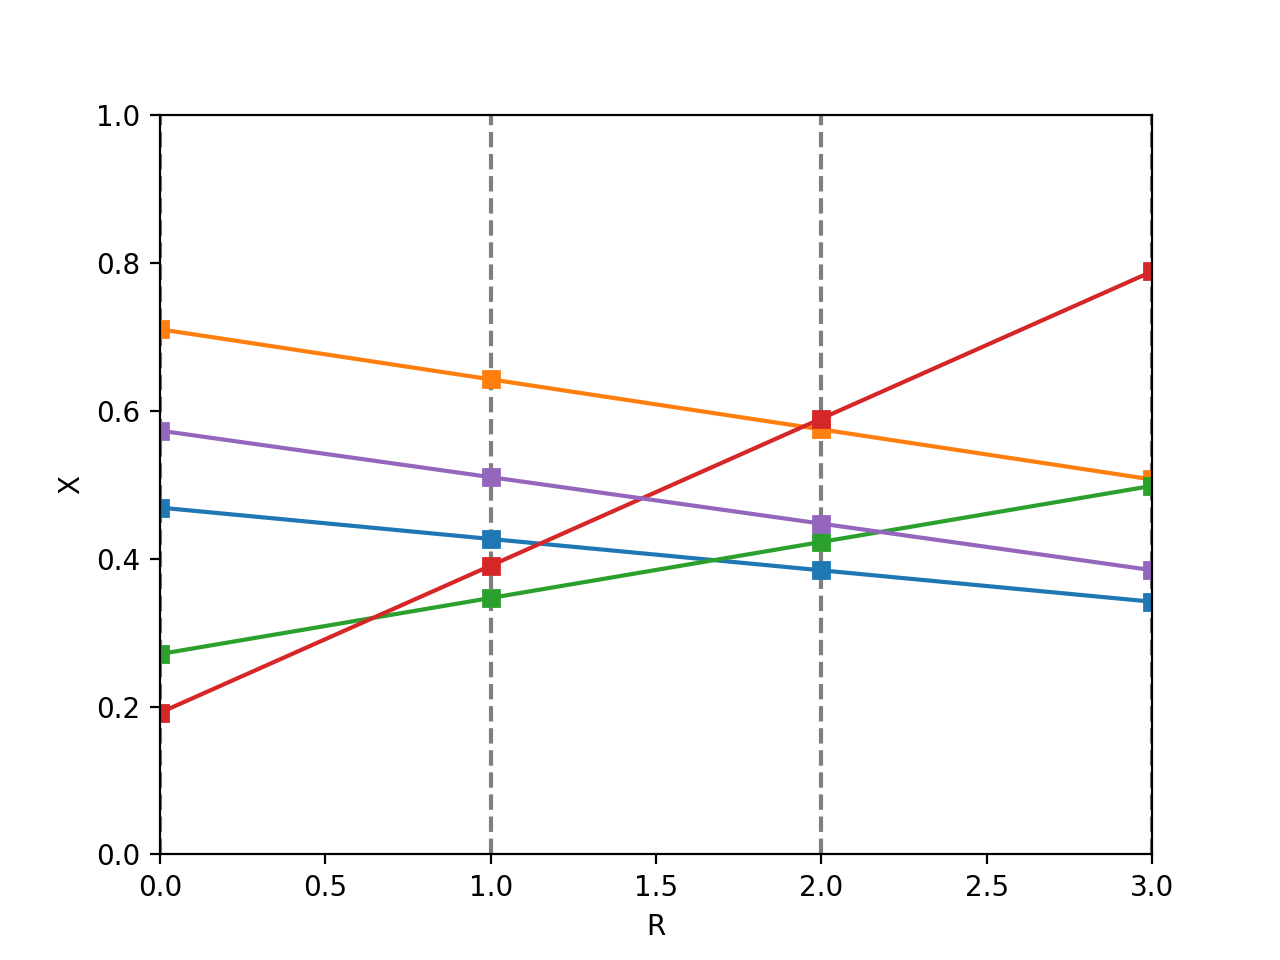

In [4]:
# Visualize the tracks
plt.figure()
for r in det_r:
    plt.plot([r, r], [0, 1], 'k--', alpha=0.5)
for i in range(x.shape[0]):
    plt.plot(det_r, x[i], 's-')
    plt.xlim((0, det_r[-1]))
    plt.ylim((0, 1))
    plt.xlabel('R')
    plt.ylabel('X')

## Adjacency development

Let's work on constructing adjacency and degree matrices.

The appropriate adjacency weight matrix for this data should work as follows:
- if the line between two hits on adjacent layers is fully contained in the detector, the adjacency is 1
- otherwise the adjacency is 0

In [5]:
hits_l = np.zeros_like(hits_x)
hits_l[:] = np.arange(0, num_det_layers)[:, None]
print('Position x')
print(hits_x)
print('Position r')
print(hits_r)
print('Layer')
print(hits_l)
print('Particle ID')
print(hits_pid)

Position x
[[ 0.19167633  0.27107979  0.46916967  0.57327614  0.7103957 ]
 [ 0.34689468  0.3906381   0.42672722  0.51036733  0.64266517]
 [ 0.38428476  0.42270957  0.44745852  0.57493464  0.58959987]
 [ 0.34184231  0.38454972  0.49852446  0.5072041   0.78856163]]
Position r
[[ 0.  0.  0.  0.  0.]
 [ 1.  1.  1.  1.  1.]
 [ 2.  2.  2.  2.  2.]
 [ 3.  3.  3.  3.  3.]]
Layer
[[ 0.  0.  0.  0.  0.]
 [ 1.  1.  1.  1.  1.]
 [ 2.  2.  2.  2.  2.]
 [ 3.  3.  3.  3.  3.]]
Particle ID
[[3 2 0 4 1]
 [2 3 0 4 1]
 [0 2 4 1 3]
 [0 4 2 1 3]]


In [6]:
# Flatten the arrays
x = hits_x.flatten()
r = hits_r.flatten()
l = hits_l.flatten()
pid = hits_pid.flatten()

In [7]:
# Identify hits on adjacent layers
adj_l = (np.abs(l[None, :] - l[:, None]) == 1).astype(np.int)

# Calculate slopes
dr = r[None,:] - r[:,None]
dr[dr == 0] = 1e-7
slope = (x[None,:] - x[:,None]) / dr

# Calculate the entry point for each slope
x0 = x[None,:] - slope*r
# Calculate the exit point for each slope
xn = x[None,:] + slope * (det_r[-1] - r)
# Adjancency
adj_x0 = (x0 < 1) & (x0 > 0)
adj_xn = (xn < 1) & (xn > 0)
# Final adjacency matrix
adj = adj_l * adj_x0 * adj_xn

# Get the true adjacency matrix
adj_pid = (pid[None, :] == pid[:, None]).astype(np.int)

<IPython.core.display.Javascript object>


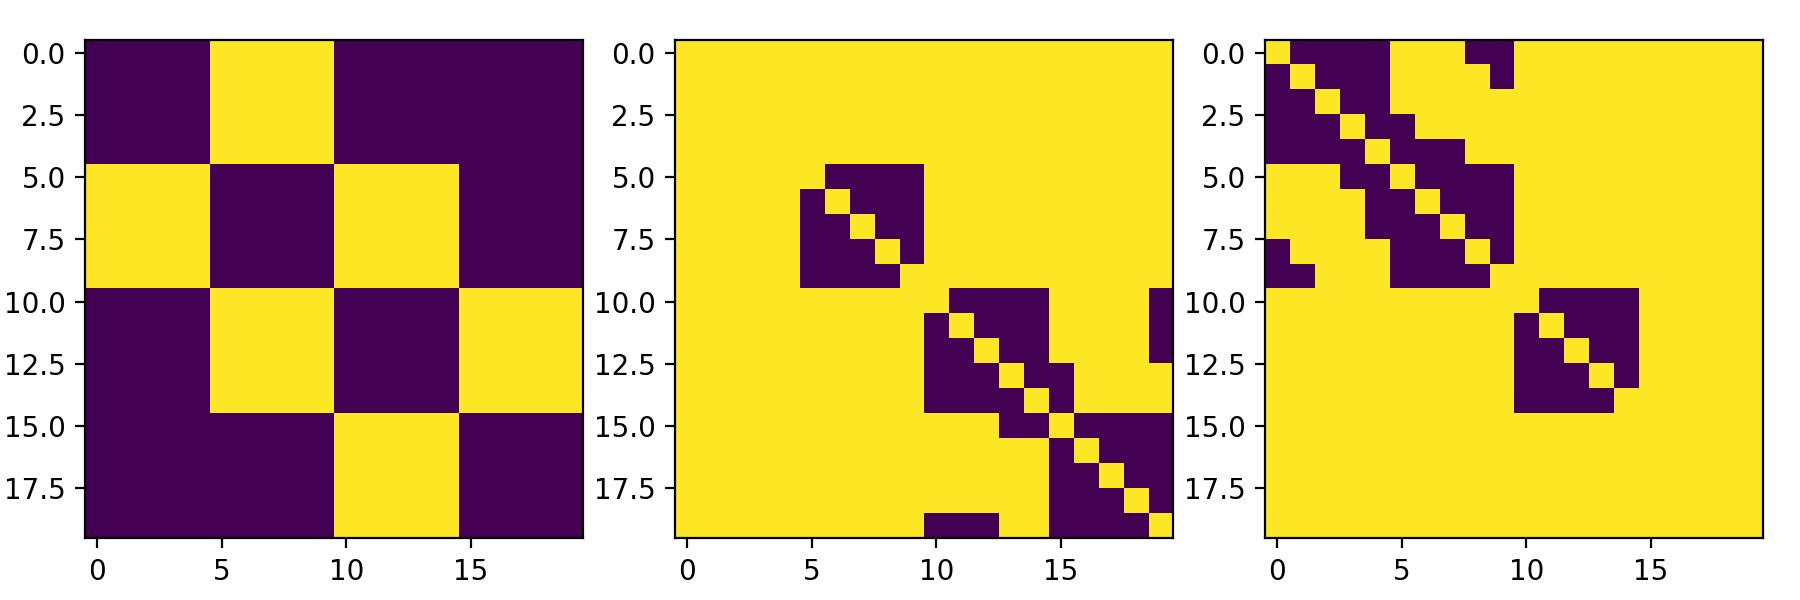

In [8]:
plt.figure(figsize=(9,3))
plt.subplot(131)
plt.imshow(adj_l)
plt.subplot(132)
plt.imshow(adj_x0)
plt.subplot(133)
plt.imshow(adj_xn)
plt.tight_layout()

<IPython.core.display.Javascript object>


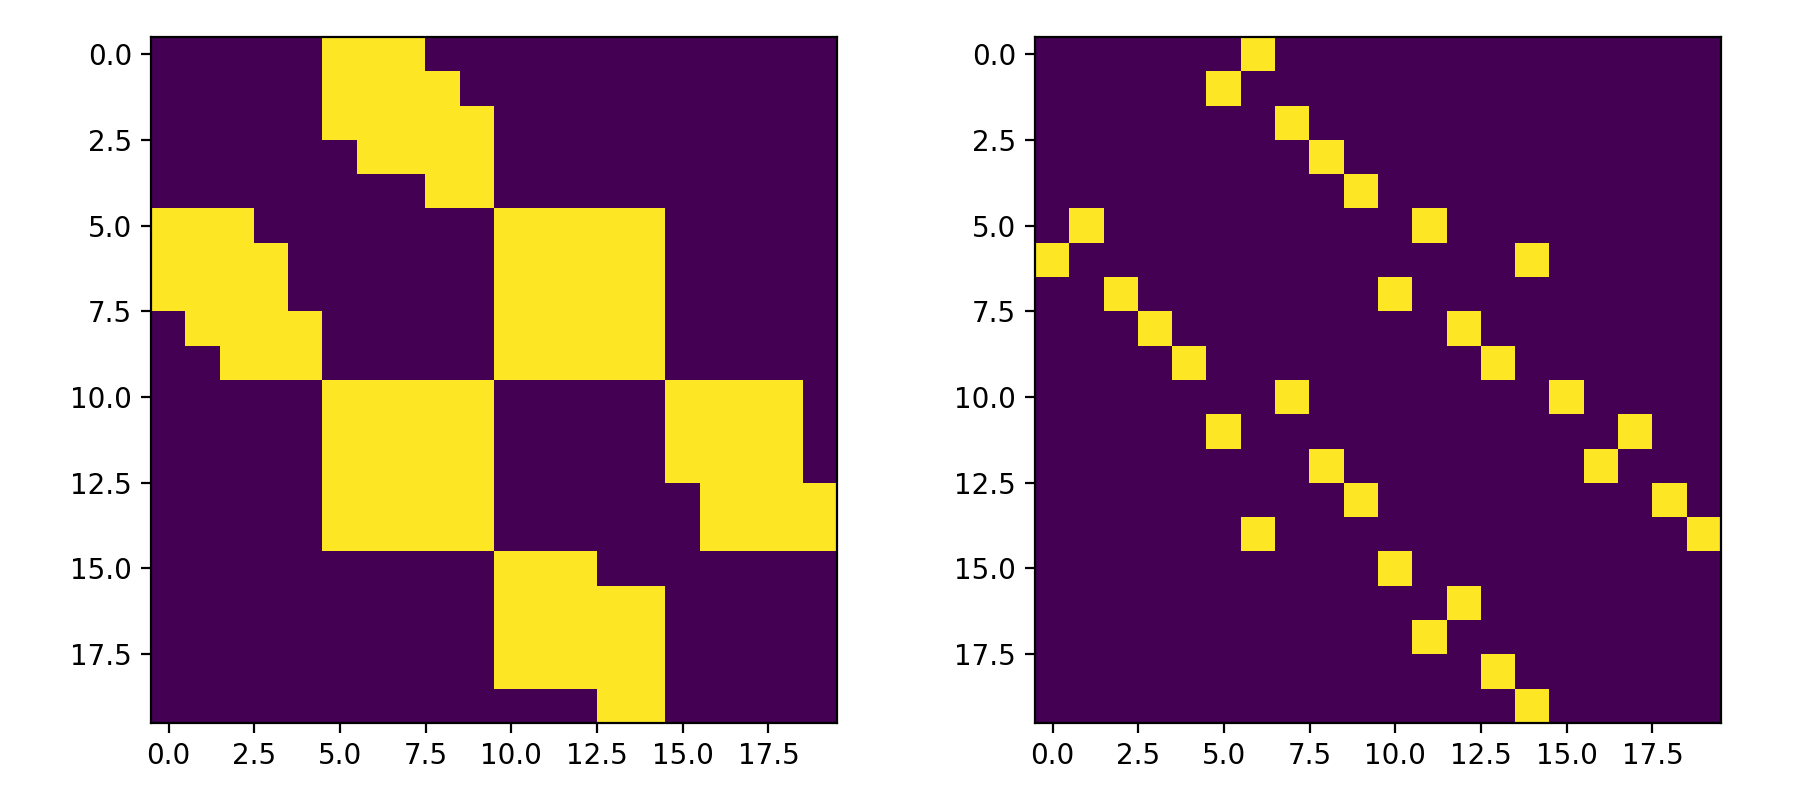

In [9]:
plt.figure(figsize=(9,4))
plt.subplot(121)
plt.imshow(adj)
plt.subplot(122)
plt.imshow(adj_pid*adj_l)
plt.tight_layout()

<IPython.core.display.Javascript object>


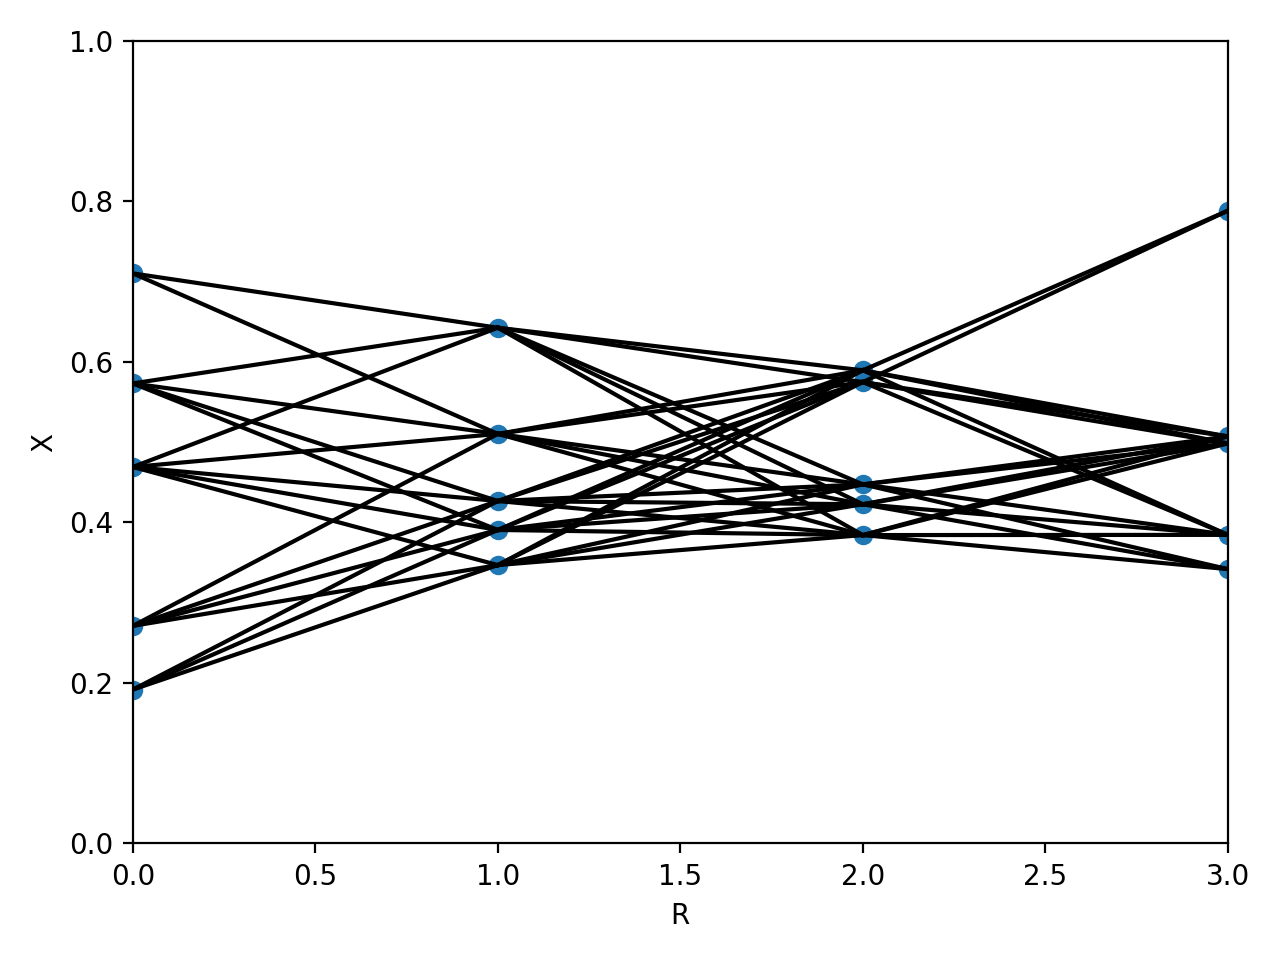

In [10]:
# Sanity check: need to draw these edges
plt.figure()

# Draw all the hits
plt.scatter(r, x)

# Loop over all hits
for i in range(x.shape[0]):
    # Loop over all other hits
    for j in range(i + 1, x.shape[0]):
        if adj[i,j] > 0:
            plt.plot([r[i], r[j]], [x[i], x[j]], 'k', alpha=adj[i,j])
plt.xlim((det_r[0], det_r[-1]))
plt.ylim((0, 1))
plt.xlabel('R')
plt.ylabel('X')
plt.tight_layout()

### Normalizing the adjacency

A typical thing to do is $D^{-1}A$, where $D$ is the diagonal degree matrix. This amounts to normalizing all edges coming into a node so they sum to 1.

The approach of Kipf and Welling is $\hat{D}^{-{1 \over 2}} \hat{A} \hat{D}^{-{1 \over 2}}$, where $\hat{A} = A + I$.

In [11]:
# The degree matrix is computed by summing the adjacency rows
deg = np.diagflat(adj.sum(axis=0))
# Inverse degree matrix
invdeg = np.diagflat(1. / adj.sum(axis=0))
# Normalized adjacency
adj_norm = invdeg.dot(adj)

In [12]:
# Symmetric (+ identity) normalized adjacency
adj_hat = np.eye(adj.shape[0]) + adj
inv_half_deg = np.diagflat(1. / np.sqrt(adj_hat.sum(axis=0)))
adj_hat_norm = inv_half_deg.dot(adj_hat.dot(inv_half_deg))

<IPython.core.display.Javascript object>


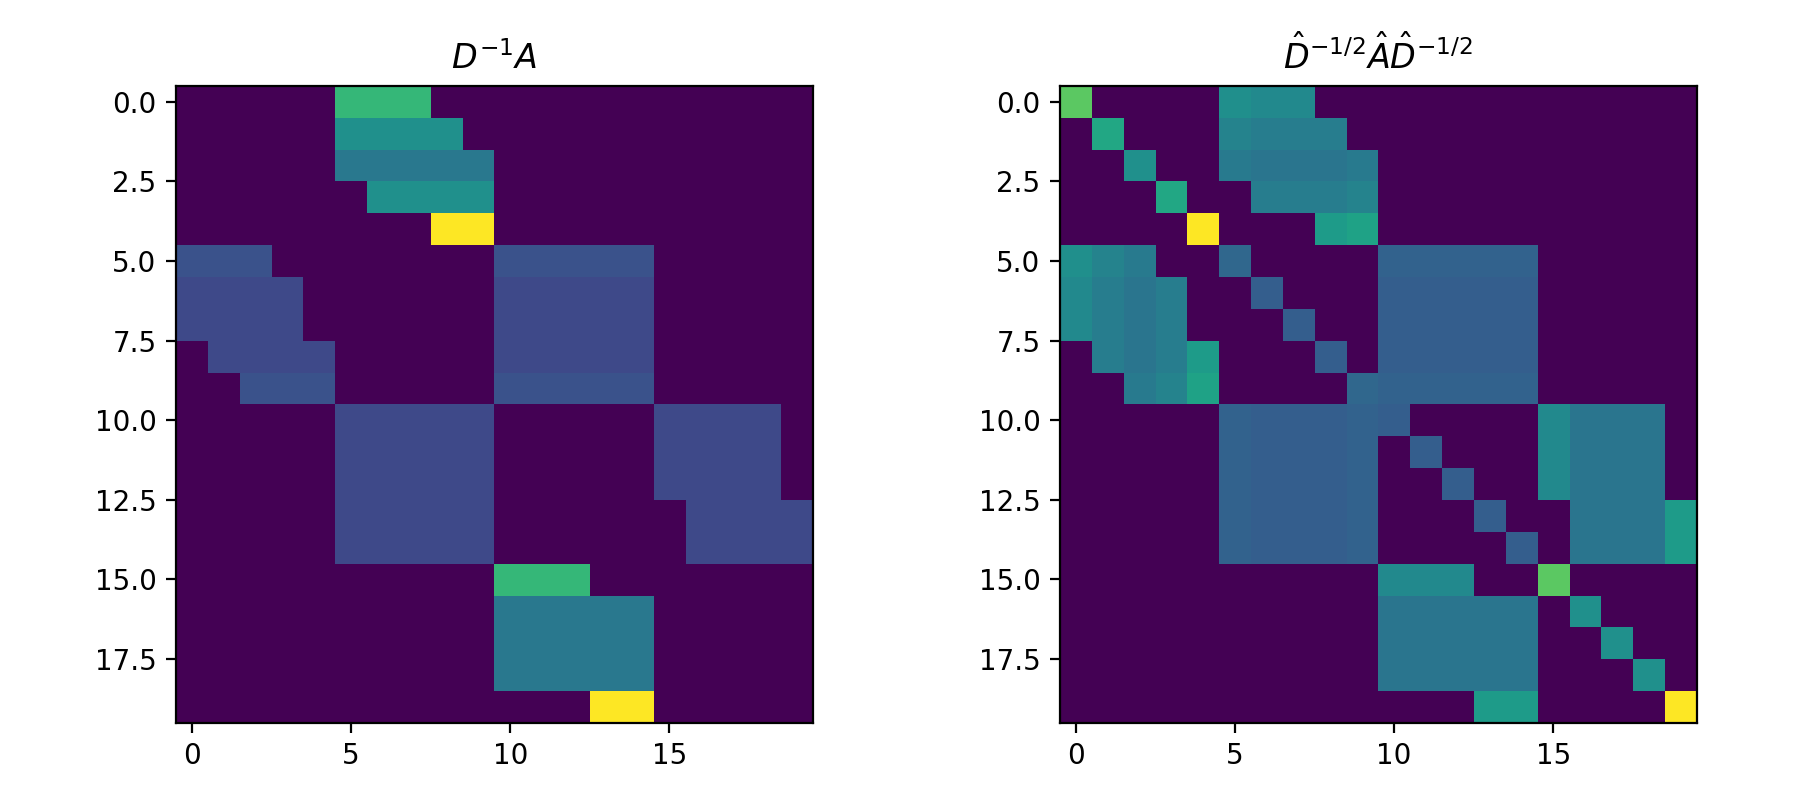

In [13]:
# Normalized adjacency matrix
plt.figure(figsize=(9,4))
plt.subplot(121)
plt.imshow(adj_norm)
plt.title('$D^{-1}A$')

plt.subplot(122)
plt.imshow(adj_hat_norm)
plt.title('$\hat{D}^{-1/2} \hat{A} \hat{D}^{-1/2}$')
plt.tight_layout()

## Graph convolutional layers

Now let's develop the operations that make up graph convolutions.

In [14]:
n_features = 2
n_hidden = 5

In [15]:
# Weight matrix has shape (features_in, features_out)
W = np.random.normal(size=(n_features, n_hidden))
b = np.zeros((1, n_hidden))

In [16]:
X = np.stack([hits_x, hits_r], axis=-1).reshape((-1, n_features))
X.shape

(20, 2)

In [17]:
# A*X*W
adj.dot(X).dot(W) + b

array([[  3.70542838,   4.38856706,   2.16017457,   0.74759995,  -0.4395014 ],
       [  5.07712503,   5.94542177,   2.86585089,   0.99077323,
         -0.59889497],
       [  6.59656197,   7.60397586,   3.55596717,   1.22742609,
         -0.77223783],
       [  5.4074193 ,   6.17278508,   2.83106423,   0.97619592,
         -0.63008059],
       [  2.89113359,   3.2154088 ,   1.39579259,   0.47982613,
         -0.33273643],
       [ 11.75961567,  14.22117349,   7.2629117 ,   2.51811908,
         -1.40912715],
       [ 12.39980739,  14.66185965,   7.19548658,   2.48986465,
         -1.46957256],
       [ 12.39980739,  14.66185965,   7.19548658,   2.48986465,
         -1.46957256],
       [ 12.97907421,  15.06060718,   7.13447809,   2.46429911,
         -1.52426558],
       [ 12.67635267,  14.85222399,   7.16636078,   2.47765952,
         -1.49568332],
       [ 18.15194523,  22.90981372,  12.54067599,   4.36198315,
         -2.22184415],
       [ 18.15194523,  22.90981372,  12.54067599,  

In [18]:
# D^-1 * A * X * W
adj_norm.dot(X).dot(W) + b

array([[ 1.23514279,  1.46285569,  0.72005819,  0.24919998, -0.14650047],
       [ 1.26928126,  1.48635544,  0.71646272,  0.24769331, -0.14972374],
       [ 1.31931239,  1.52079517,  0.71119343,  0.24548522, -0.15444757],
       [ 1.35185482,  1.54319627,  0.70776606,  0.24404898, -0.15752015],
       [ 1.4455668 ,  1.6077044 ,  0.6978963 ,  0.23991307, -0.16636821],
       [ 1.46995196,  1.77764669,  0.90786396,  0.31476488, -0.17614089],
       [ 1.37775638,  1.62909552,  0.79949851,  0.27665163, -0.16328584],
       [ 1.37775638,  1.62909552,  0.79949851,  0.27665163, -0.16328584],
       [ 1.44211936,  1.6734008 ,  0.79271979,  0.27381101, -0.16936284],
       [ 1.58454408,  1.856528  ,  0.8957951 ,  0.30970744, -0.18696041],
       [ 2.0168828 ,  2.54553486,  1.39340844,  0.48466479, -0.24687157],
       [ 2.0168828 ,  2.54553486,  1.39340844,  0.48466479, -0.24687157],
       [ 2.0168828 ,  2.54553486,  1.39340844,  0.48466479, -0.24687157],
       [ 2.07231198,  2.58369041,  1.3

In [19]:
# D^(-1/2) * A * D^(-1/2) * X * W + b
adj_hat_norm.dot(X).dot(W) + b

array([[ 0.64956258,  0.74297018,  0.34211759,  0.11799291, -0.07575963],
       [ 0.78765497,  0.89343463,  0.40446137,  0.13936628, -0.09150047],
       [ 0.9578496 ,  1.06335539,  0.45975812,  0.15801316, -0.11014348],
       [ 0.90438637,  0.97378855,  0.3921672 ,  0.13421442, -0.10252198],
       [ 0.80729103,  0.78546105,  0.23380047,  0.0782702 , -0.0874287 ],
       [ 1.41409971,  1.68725151,  0.84165726,  0.29147621, -0.16833364],
       [ 1.43052212,  1.65861071,  0.78449517,  0.27094827, -0.16793585],
       [ 1.43455228,  1.66138493,  0.78407071,  0.2707704 , -0.16831636],
       [ 1.55488747,  1.74421957,  0.77139699,  0.26545949, -0.17967813],
       [ 1.61810505,  1.82768182,  0.82017138,  0.28247257, -0.18759535],
       [ 2.45023019,  3.12452077,  1.73727537,  0.60468998, -0.30147776],
       [ 2.45452119,  3.12747454,  1.73682344,  0.6045006 , -0.30188291],
       [ 2.45728497,  3.12937703,  1.73653236,  0.60437862, -0.30214386],
       [ 2.63077118,  3.29375404,  1.7

## Generate a dataset

In [20]:
det_r = np.array([0, 1, 2, 3], dtype=np.float)
n_det_layers = det_r.shape[0]
n_events = 1024
n_tracks = 5

In [21]:
def generate_data(n_events, n_tracks, det_r):
    n_det_layers = det_r.shape[0]

    # Generate all the tracks we'll need
    tracks = np.stack([gen_tracks(n_events, det_r)
                       for i in range(n_tracks)], axis=1)

    # Sort according to the first hit position, so the labels are
    # consistently defined in terms of the first layer hit order.
    # Note: singleton ('None') idx axes indicate a repeat-broadcast.
    idx0 = np.arange(n_events)[:, None, None]
    idx1 = tracks[:, :, 0].argsort(axis=1)[:, :, None]
    idx2 = np.arange(n_det_layers)[None, None, :]
    tracks = tracks[[idx0, idx1, idx2]]
    tracks.shape

    # Now sort all hits on all layers by their position.
    # This sort index relative to previous sort gives us our hit labels.
    idx = np.argsort(tracks, axis=1)
    x = tracks[[idx0, idx, idx2]]
    
    # Transpose to shape (n_event, n_layer, n_hit)
    return x.transpose([0,2,1]), idx.transpose([0,2,1])

In [22]:
# Hit position and label
hits_x, hits_y = generate_data(n_events, n_tracks, det_r)
# Hit radius
hits_r = np.broadcast_to(det_r[None, :, None], hits_x.shape)
# Layer number
hits_l = np.broadcast_to(np.arange(n_det_layers)[None, :, None], hits_x.shape)
print(hits_x.shape, hits_y.shape)

# Flattened arrays
x, y, r, l = [a.reshape((n_events, -1)) for a in [hits_x, hits_y, hits_r, hits_l]]
print(map(np.shape, [x, y, r, l]))

(1024, 4, 5) (1024, 4, 5)
[(1024, 20), (1024, 20), (1024, 20), (1024, 20)]


<IPython.core.display.Javascript object>


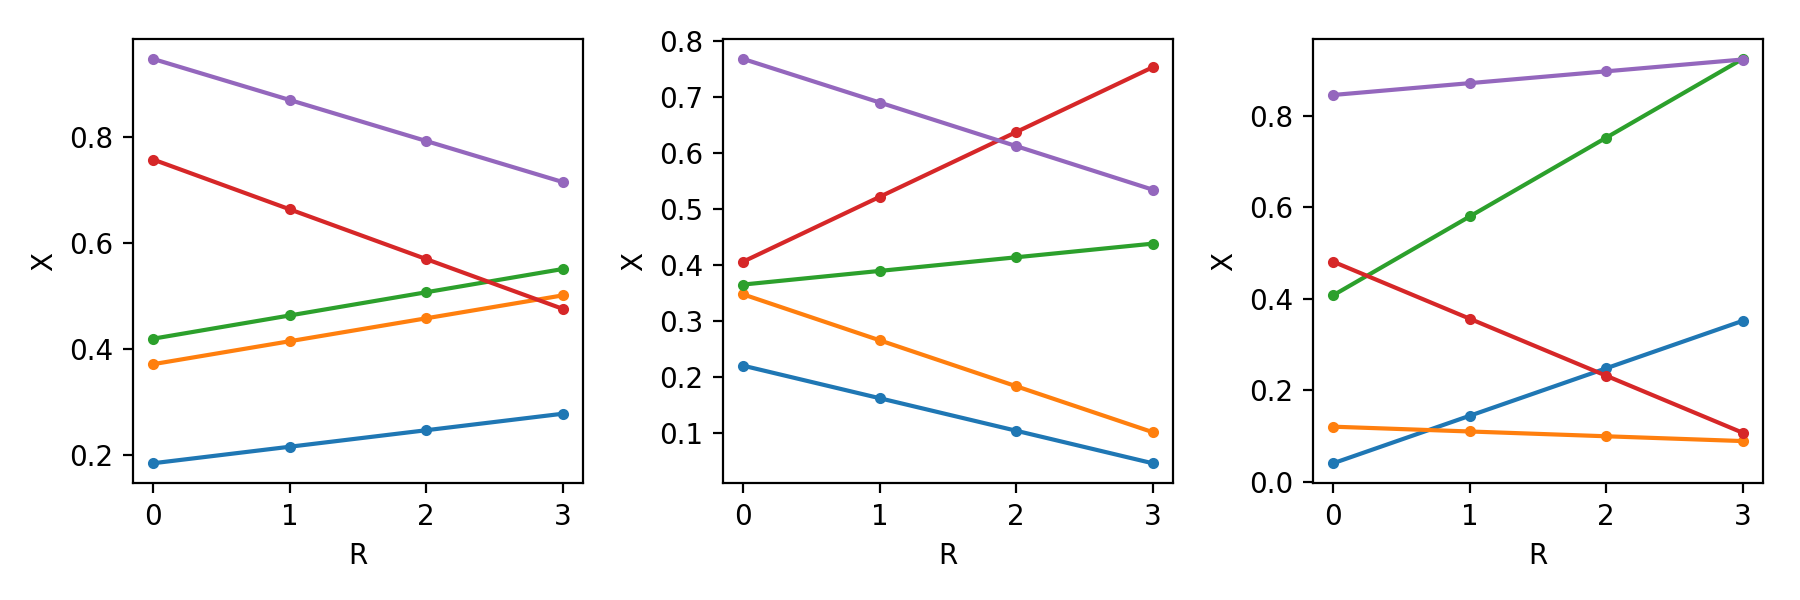

In [23]:
# As a sanity check, plot a few events
nrows, ncols = 1, 3
plt.figure(figsize=(9,3))

for i in range(nrows*ncols):
    plt.subplot(nrows, ncols, i+1)
    xi, yi = x[i], y[i]
    for j in range(n_tracks):
        plt.plot(det_r, xi[yi==j], '.-')
    plt.xlabel('R')
    plt.ylabel('X')
plt.tight_layout()

### Calculating adjacency

Extend the adjacency calculations to work on batches or full datasets

Adjacency tensor will have shape (n_events, n_hits, n_hits), where n_hits = n_tracks * n_det_layers.

In [24]:
def calc_adjacency(x, r, l, y):
    """Calculate toy data adjacency matrices"""
    # Detector layer adjacency
    adj_l = (np.abs(l[:, None, :] - l[:, :, None]) == 1).astype(np.int)
    # Hit-pair-wise slopes
    dx = x[:, None, :] - x[:, :, None]
    dr = r[:, None, :] - r[:, :, None]
    # Div-by-zero protection
    dr[dr == 0] = 1e-7
    slope = dx / dr
    # Entry and exit points for each slope
    rn = r.max()
    x0 = x[:, None, :] - slope * r[:, None, :]
    xn = x[:, None, :] + slope * (rn - r[:, None, :])
    # Adjacency from entry and exit constraints
    adj_x0 = (x0 < 1) & (x0 > 0)
    adj_xn = (xn < 1) & (xn > 0)
    # Final combined adjacency matrices
    adj = adj_l * adj_x0 * adj_xn
    # True adjacency matrix
    adj_y = (y[:, None, :] == y[:, :, None]) * adj_l
    return adj, adj_y

In [25]:
# Adjacency matrices for all events
adj, adj_y = calc_adjacency(x, r, l, y)

<IPython.core.display.Javascript object>


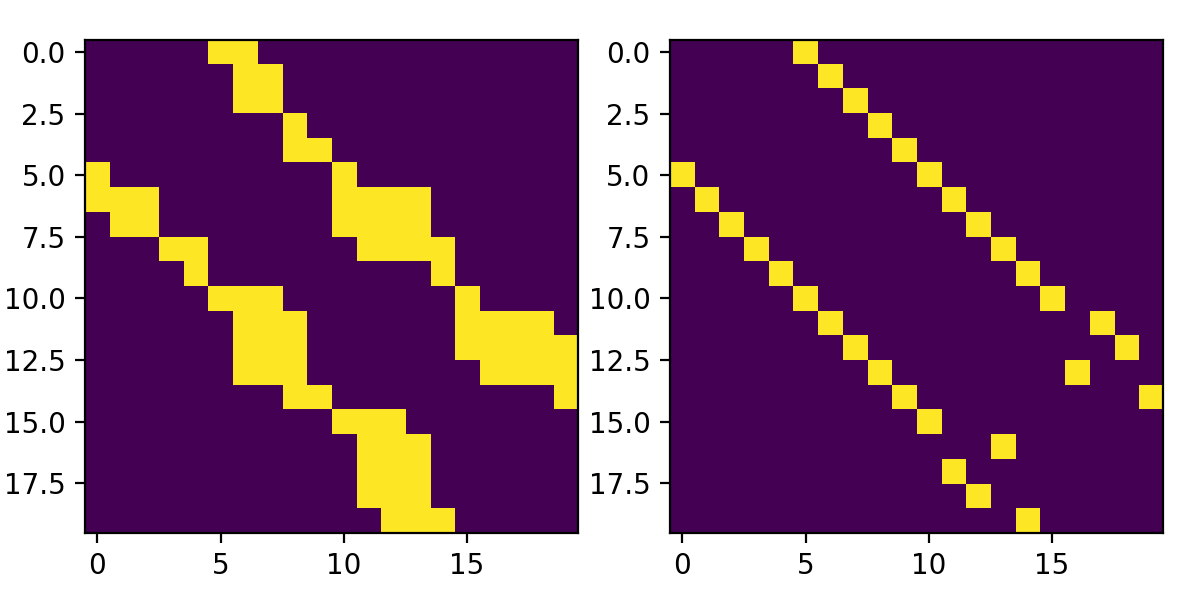

<IPython.core.display.Javascript object>


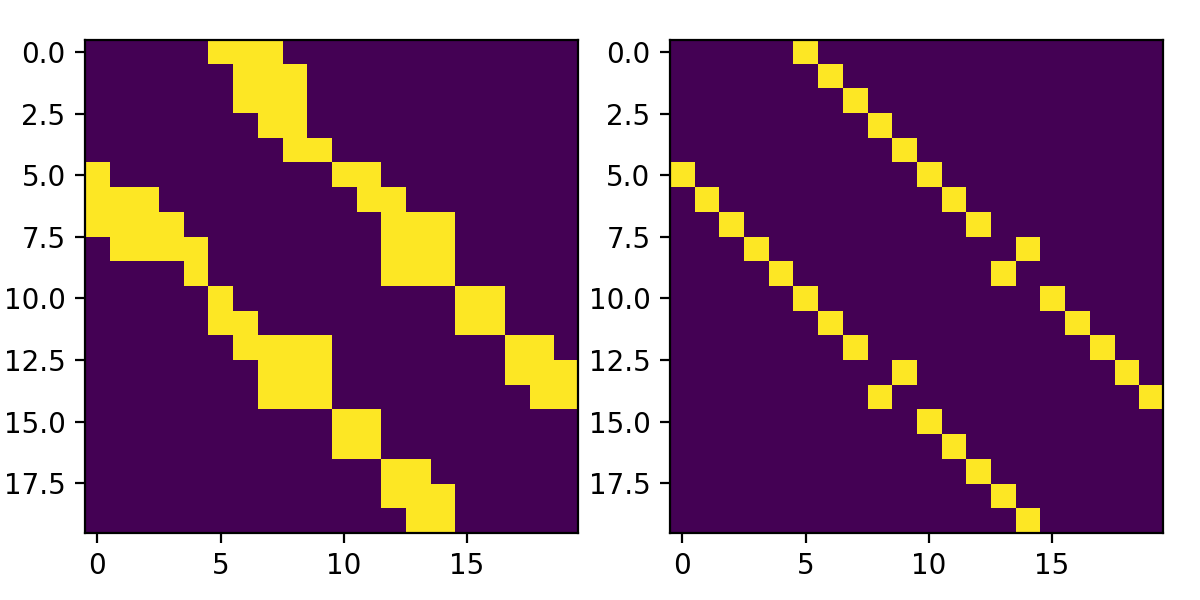

In [26]:
# Draw some adjacency matrices
for i in range(2):
    plt.figure(figsize=(6, 3))
    plt.subplot(121)
    plt.imshow(adj[i])
    plt.subplot(122)
    plt.imshow(adj_y[i])
    plt.tight_layout()

## Dual graph construction

Now that we have all the machinery to work with the graph of hits, let's work on the machinery to work with the complementary graph consisting of segments as nodes and hits as edges. Such a formulation may be effective for representing the relevant hit relationships.

In [27]:
# From an adjacency matrix, we can extract the list of edges as node indices.

In [34]:
a = adj[0]

In [38]:
# Use just the upper triangle to find the edges
a_triu = np.triu(a)

In [44]:
seg_idx = np.stack(a_triu.nonzero(), axis=-1)

In [45]:
seg_idx

array([[ 0,  5],
       [ 0,  6],
       [ 1,  6],
       [ 1,  7],
       [ 2,  6],
       [ 2,  7],
       [ 3,  8],
       [ 4,  8],
       [ 4,  9],
       [ 5, 10],
       [ 6, 10],
       [ 6, 11],
       [ 6, 12],
       [ 6, 13],
       [ 7, 10],
       [ 7, 11],
       [ 7, 12],
       [ 7, 13],
       [ 8, 11],
       [ 8, 12],
       [ 8, 13],
       [ 8, 14],
       [ 9, 14],
       [10, 15],
       [11, 15],
       [11, 16],
       [11, 17],
       [11, 18],
       [12, 15],
       [12, 16],
       [12, 17],
       [12, 18],
       [12, 19],
       [13, 16],
       [13, 17],
       [13, 18],
       [13, 19],
       [14, 19]])

Now what? I need to somehow build an adjacency matrix out of these segments. I should be able to match endpoints together for that.

As with the original graph representation, I can build multiple adjacencies to model competing neighbors. So, the primary adjacency is defined by pairing incoming segments with outgoing segments. A second adjacency could relate incomings to incomings and outgoings to other outgoings on the same hit.

In [46]:
# Build a binary segment adjacency which pairs incoming to outgoing segments on hits.

# Construct the empty adjacency matrix first
n_segs = seg_idx.shape[0]
seg_adj = np.zeros((n_segs, n_segs))

In [56]:
# Loop over segments
for iseg in range(n_segs):
    # Loop over other segments
    for jseg in range(iseg, n_segs):
        
        # Match hits
        if seg_idx[iseg, 1] == seg_idx[jseg, 0]:
            
            # Mark adjacent
            seg_adj[iseg, jseg] = 1

# Symmetrize the adjacency by adding the reverse terms
seg_adj += seg_adj.T

<IPython.core.display.Javascript object>


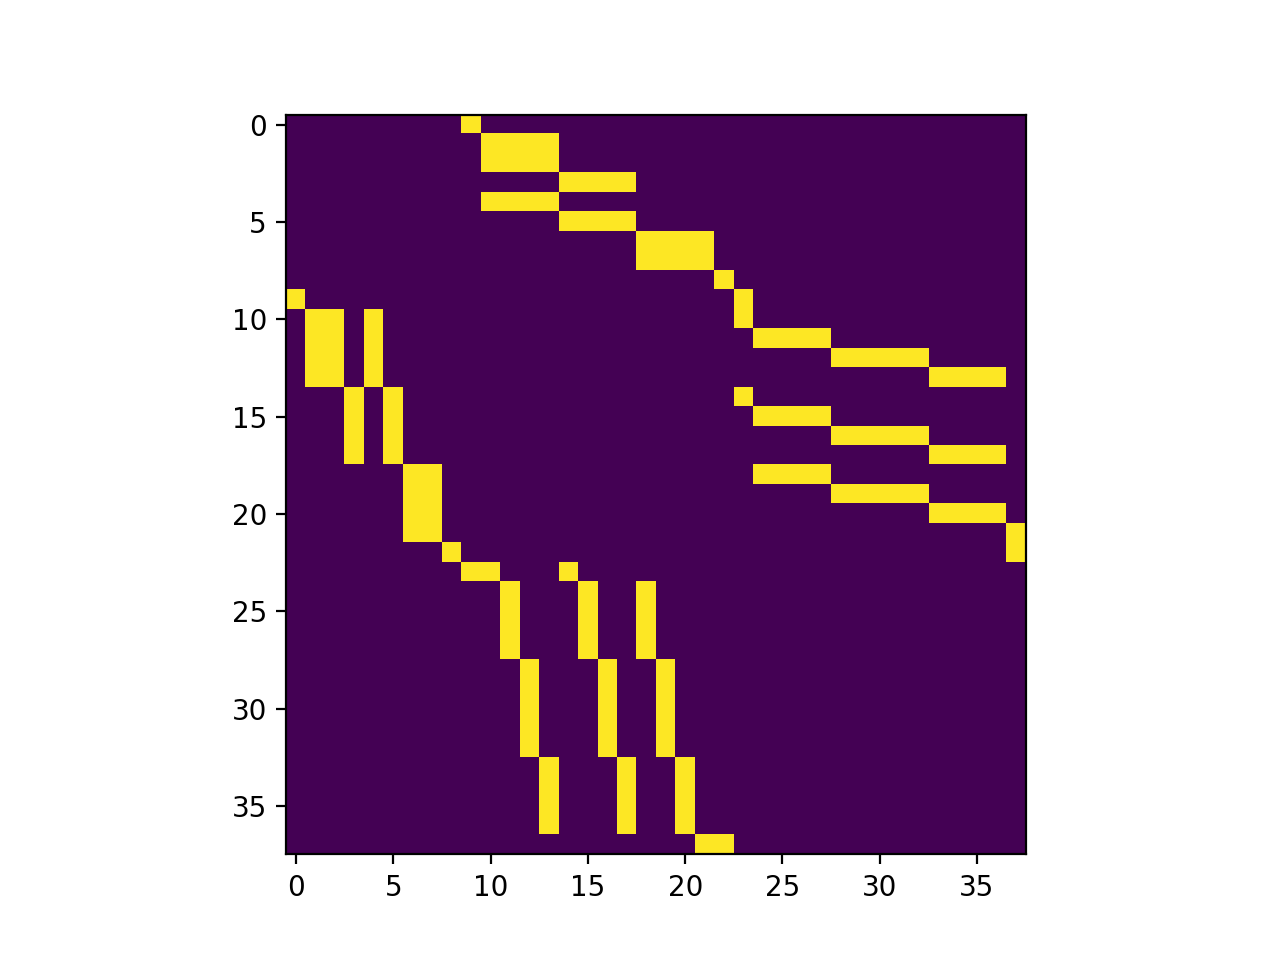

In [57]:
plt.figure()
plt.imshow(seg_adj)

So that gives me the binary adjacency, but now how do we go beyond that and start to quantify the compatibility between segments? Each segment has its own line parameters, a slope and an intercept, which can be used to compute a similarity.

For this dumb toy problem, there is a trivial construction which fully solves the problem. I just require the slopes to match up perfectly. Since this won't be an option in the real world, we won't bother with that.

I could use a gaussian for the slope difference. This is certainly too broad of a distribution for this data (unless I start doing some gaussian smearing!), but might work.

How do I choose the width of the gaussian? 
- I guess I can set it arbitrarily small for my first actual toy model tests.
- It might be useful to define it as some fraction of the allowed slope range.

In [102]:
# Compute the slopes of each segment
seg_slopes = (np.diff(x[0, seg_idx]) / np.diff(r[0, seg_idx])).squeeze(-1)

<IPython.core.display.Javascript object>


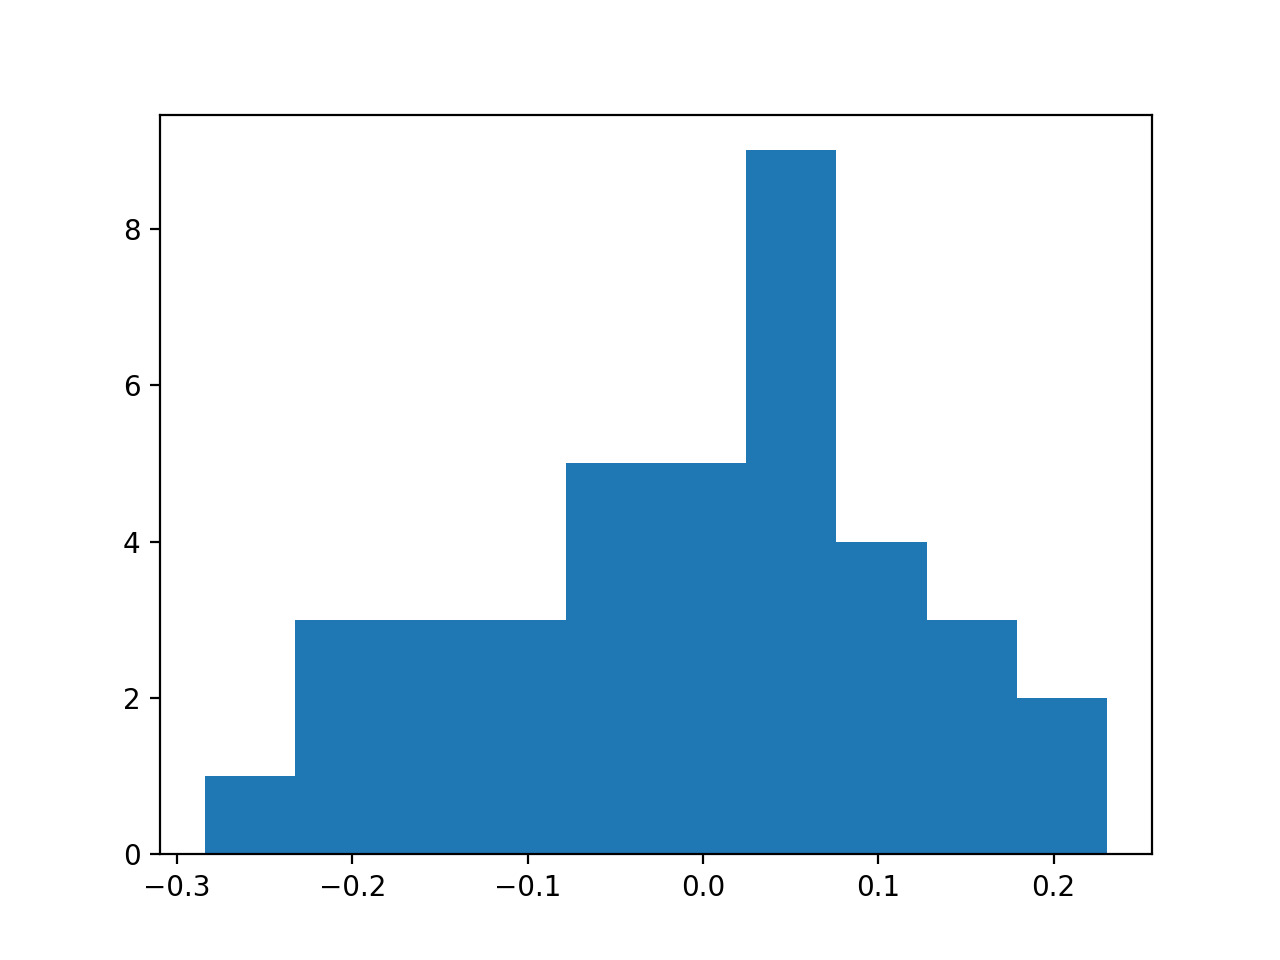

(array([ 1.,  3.,  3.,  3.,  5.,  5.,  9.,  4.,  3.,  2.]),
 array([-0.28398288, -0.23254188, -0.18110089, -0.1296599 , -0.07821891,
        -0.02677791,  0.02466308,  0.07610407,  0.12754507,  0.17898606,
         0.23042705]),
 <a list of 10 Patch objects>)

In [97]:
plt.figure()
plt.hist(seg_slopes)

Now, we want to compute the difference between slopes of adjacent segments.

In [104]:
dslopes = seg_slopes[None, :] - seg_slopes[:, None]

In [105]:
dslopes.shape

(38, 38)

<IPython.core.display.Javascript object>


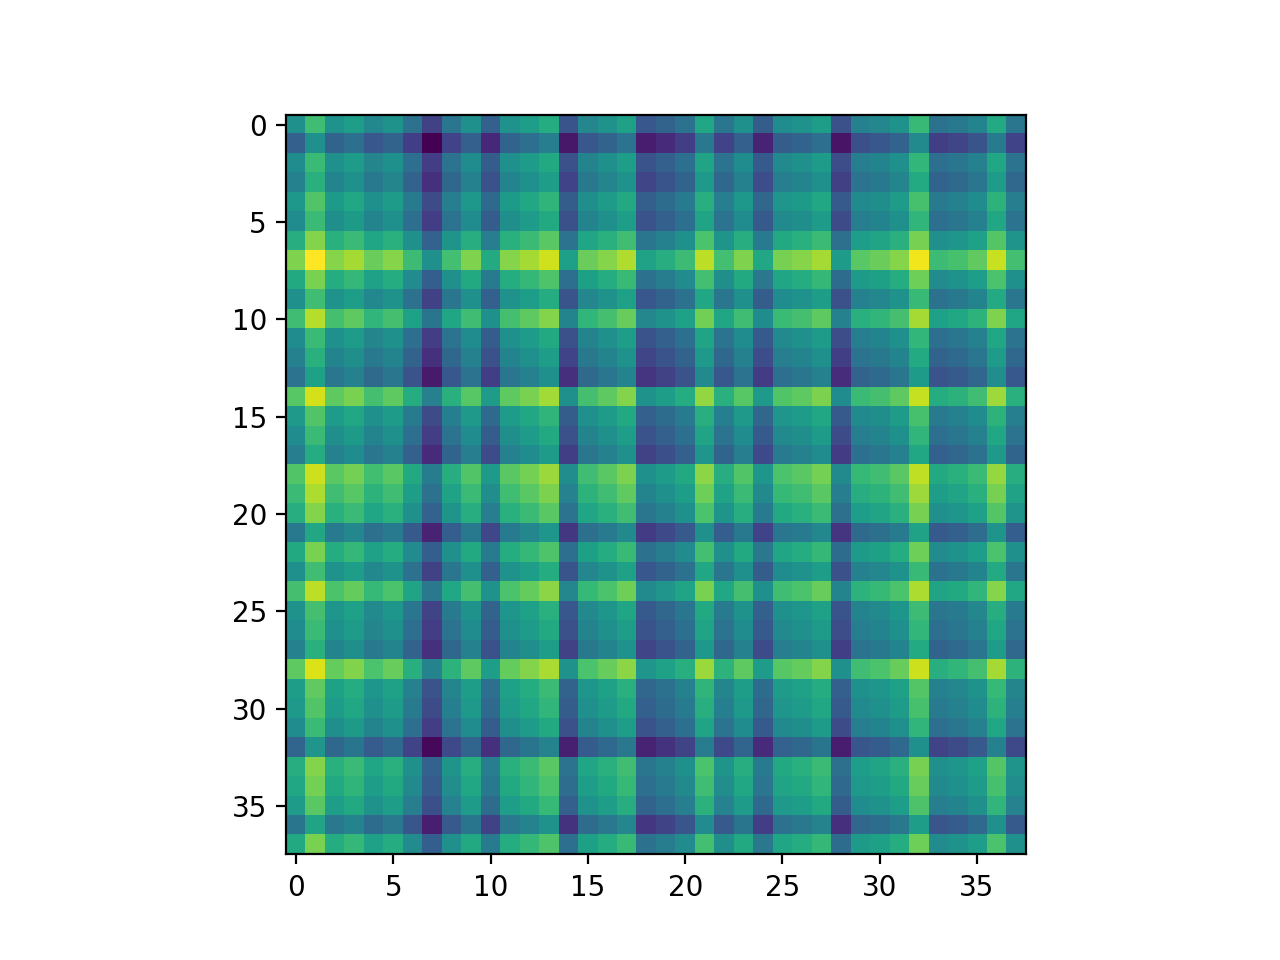

In [107]:
plt.figure()
plt.imshow(dslopes)

https://wikimedia.org/api/rest_v1/media/math/render/svg/8aa9ff808602c27f1d9d63d7b2c115388a34f190

In [ ]:
def gaus_kernel(dx, sig):
    return np.exp(-(dx**2) / (2*sig**2))

In [130]:
sig = 0.1
v = sig ** 2
adj_kernel = np.exp(-(dslopes ** 2) / (2 * v))

<IPython.core.display.Javascript object>


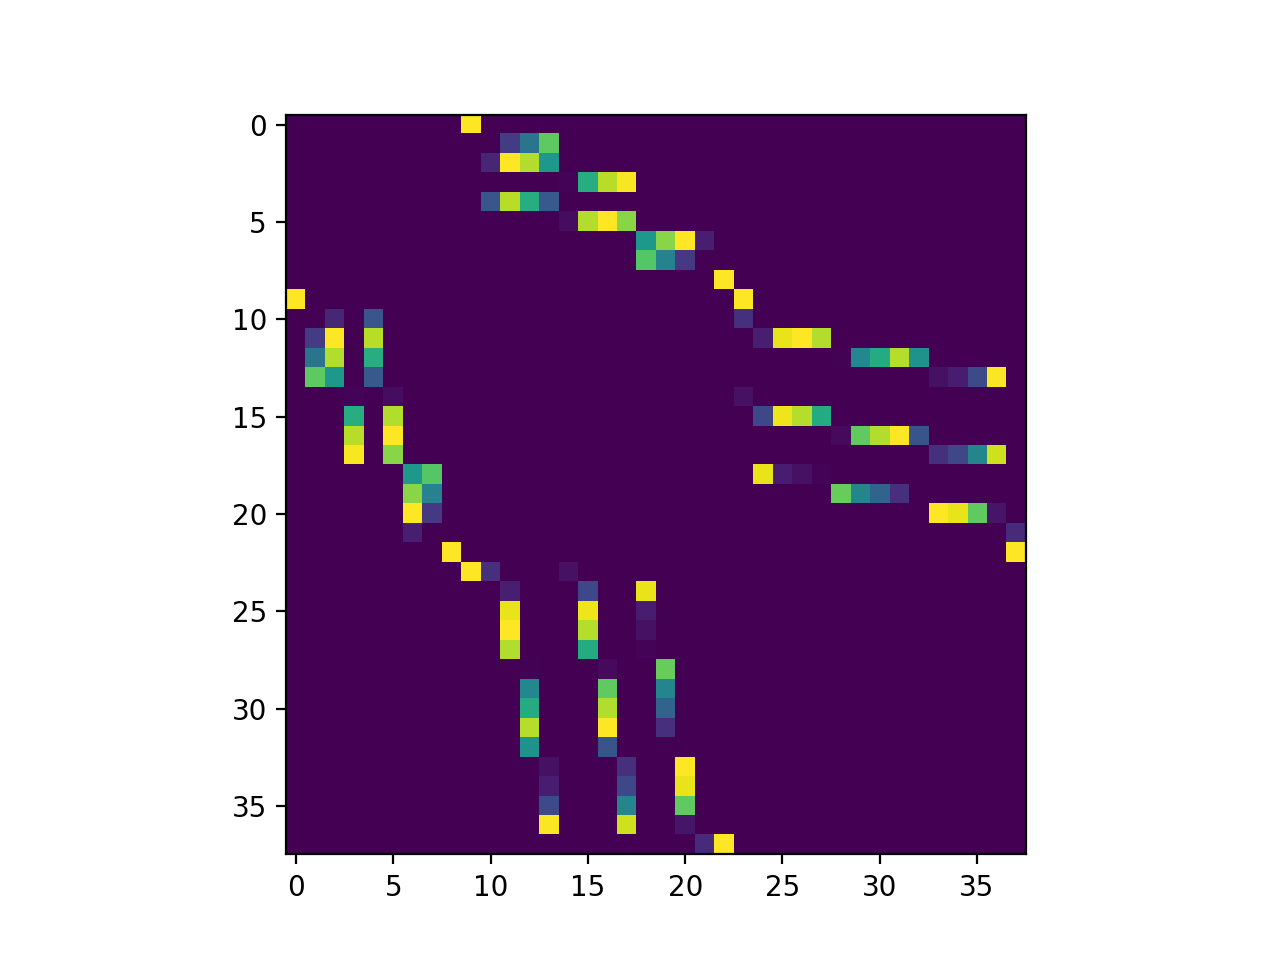

In [131]:
plt.figure()
plt.imshow(adj_kernel * seg_adj)